In [1]:
%%capture
import torch

# 1. Unsloth'u Ana Paket Olarak Kur
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# 2. KRİTİK ADIM: Xformers'ı Hazır Paket (Binary) Olarak Zorla Yükle
# Bu satır "Building wheels" hatasını engeller.
!pip install xformers --index-url https://download.pytorch.org/whl/cu121 --no-deps

# 3. Diğerlerini versiyon kontrolü yapmadan hızlıca kur
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

In [2]:
from google.colab import drive
import os

print("🔌 Google Drive Bağlanıyor...")
drive.mount('/content/drive')

# Dosya yolunu kontrol edelim
hedef_dosya = "/content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler/din_train.json"

if os.path.exists(hedef_dosya):
    print(f"\n✅ DOSYA BULUNDU: {hedef_dosya}")
    print("🚀 Eğitim kodunu tekrar çalıştırabilirsin!")
else:
    print(f"\n❌ DOSYA BULUNAMADI: {hedef_dosya}")
    print("📂 'Proje_Yedekleri' klasörünün içeriği listeleniyor:")

    # Klasör var mı bakalım?
    klasor_yolu = "/content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler"
    if os.path.exists(klasor_yolu):
        print(os.listdir(klasor_yolu))
    else:
        print("⚠️ 'Sozel_Veriler' klasörü bile bulunamadı! Yol isminde hata olabilir mi?")
        # Bir üst klasöre bakalım
        ust_klasor = "/content/drive/MyDrive/Proje_Yedekleri"
        if os.path.exists(ust_klasor):
            print(f"Bunun yerine şu klasör var: {ust_klasor}")
            print(os.listdir(ust_klasor))

🔌 Google Drive Bağlanıyor...
Mounted at /content/drive

✅ DOSYA BULUNDU: /content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler/din_train.json
🚀 Eğitim kodunu tekrar çalıştırabilirsin!


In [3]:
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset
import torch
import os

# ==========================================
# 1. AYARLAR & SABİTLER
# ==========================================
# Eğer Fen modellerinde r değerini değiştirdiysen burayı GÜNCELLE!
LORA_R = 16
LORA_ALPHA = 16

subject_name = "din"
base_path = "/content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler"
output_dir = f"/content/drive/MyDrive/Proje_Yedekleri/model_{subject_name}_uzmani"

print(f"🎩 {subject_name.upper()} EĞİTİMİ BAŞLATILIYOR...")
print(f"🔗 Hedeflenen Merge Parametreleri: r={LORA_R}, alpha={LORA_ALPHA}")

# ==========================================
# 2. MODEL YÜKLEME (LLAMA 3.1 8B)
# ==========================================
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)

# LoRA Adaptörleri (Fen modelleriyle AYNI OLMALI)
model = FastLanguageModel.get_peft_model(
    model,
    r = LORA_R,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = LORA_ALPHA,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

# ==========================================
# 3. VERİ SETİ & PROMPT
# ==========================================
train_file = f"{base_path}/{subject_name}_train.json"
dataset = load_dataset("json", data_files={"train": train_file}, split="train")

# Qwen ile oluşturduğun o güzel açıklamaları (rationale) modele öğretiyoruz!
prompt_template = """Aşağıdaki soruyu analiz et ve doğru seçeneği bul.

### Soru:
{}

### Seçenekler:
{}

### Mantıksal Çözüm Yolu:
{}

### Doğru Cevap:
{}""" + tokenizer.eos_token

def formatting_prompts_func(examples):
    questions = examples["question"]
    options = examples["options"]
    corrects = examples["correct"]
    rationales = examples["rationale"] # Qwen'in doldurduğu alan

    texts = []
    for q, opts, corr, rat in zip(questions, options, corrects, rationales):
        opts_str = "\n".join([str(x) for x in opts]) if isinstance(opts, list) else str(opts)
        # Eğer rationale boşsa veya None ise basit bir metin koy (Hata önleyici)
        rat_text = rat if rat and len(str(rat)) > 5 else f"Bu soru {subject_name} bilgisi gerektirir."

        text = prompt_template.format(q, opts_str, rat_text, corr)
        texts.append(text)
    return {"text": texts}

dataset = dataset.map(formatting_prompts_func, batched = True)

# ==========================================
# 4. EĞİTİMİ BAŞLAT (TRAINER)
# ==========================================
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 4, # A100 olduğu için 8 bile yapabilirsin ama 4 güvenli
        gradient_accumulation_steps = 4, # Batch 4 * Grad 4 = 16 efektif batch size
        warmup_steps = 5,
        max_steps = 300, # 400 veri için 1-2 epoch yeterlidir, ezberlemesin (Overfit riskine karşı)
        learning_rate = 3e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Wandb kullanmıyorsan kapat
    ),
)

trainer_stats = trainer.train()

# ==========================================
# 5. KAYDETME (Drive'a)
# ==========================================
print(f"\n💾 Model Kaydediliyor: {output_dir} ...")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"\n✅ FELSEFE EĞİTİMİ TAMAMLANDI! Drive'a kaydedildi.")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
JITCallable._set_src() takes 1 positional argument but 2 were given
🎩 DIN EĞİTİMİ BAŞLATILIYOR...
🔗 Hedeflenen Merge Parametreleri: r=16, alpha=16
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/400 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 12 | Total steps = 300
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.052700
2,1.993200
3,1.930900
4,1.886800
5,1.703700
6,1.600900
7,1.459600
8,1.420800
9,1.477100
10,1.538500



💾 Model Kaydediliyor: /content/drive/MyDrive/Proje_Yedekleri/model_din_uzmani ...

✅ FELSEFE EĞİTİMİ TAMAMLANDI! Drive'a kaydedildi.


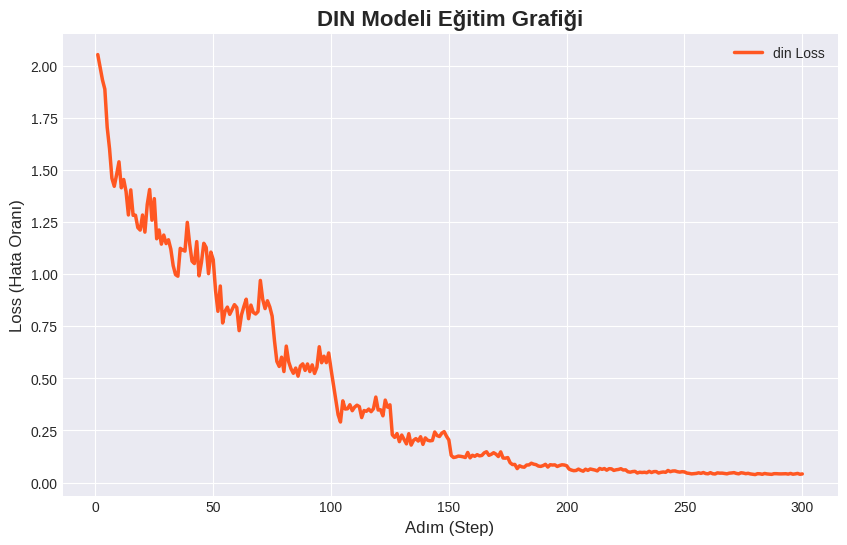


📈 Grafik şuraya kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Grafikler/din_loss_graph.png
📉 Başlangıç Loss: 2.0527
✅ Bitiş Loss: 0.0412


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Grafik stili
plt.style.use('seaborn-v0_8-darkgrid')

def plot_training_history(trainer, subject_name, save_dir):
    # 1. Log geçmişini çek
    history = trainer.state.log_history

    # 2. Sadece 'loss' olan adımları ayıkla
    data = []
    for entry in history:
        if 'loss' in entry:
            data.append({
                'Step': entry['step'],
                'Training Loss': entry['loss'],
                'Epoch': entry['epoch']
            })

    if not data:
        print("⚠️ Hata: Eğitim loglarında 'loss' verisi bulunamadı.")
        return

    df = pd.DataFrame(data)

    # 3. Grafiği Çiz
    plt.figure(figsize=(10, 6))

    # Ana çizgi
    sns.lineplot(data=df, x='Step', y='Training Loss', label=f'{subject_name} Loss', linewidth=2.5, color='#FF5722')

    # Başlık ve Etiketler
    plt.title(f'{subject_name.upper()} Modeli Eğitim Grafiği', fontsize=16, fontweight='bold')
    plt.xlabel('Adım (Step)', fontsize=12)
    plt.ylabel('Loss (Hata Oranı)', fontsize=12)
    plt.legend()

    # 4. Kaydet
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = f"{save_dir}/{subject_name}_loss_graph.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"\n📈 Grafik şuraya kaydedildi: {save_path}")
    print(f"📉 Başlangıç Loss: {df['Training Loss'].iloc[0]:.4f}")
    print(f"✅ Bitiş Loss: {df['Training Loss'].iloc[-1]:.4f}")

# --- KULLANIM ---
# Bunu eğitim kodunun en altına ekleyebilirsin
# 'trainer' nesnesi hafızada olmalı.

output_base = "/content/drive/MyDrive/Proje_Yedekleri/Grafikler"

# Eğer döngü içindeysen 'subject' değişkenini kullan,
# tek çalıştırıyorsan elinle "din" yaz.
plot_training_history(trainer, "din", output_base)

🎓 DIN MODELİ YÜKLENİYOR: /content/drive/MyDrive/Proje_Yedekleri/model_din_uzmani...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

📝 DIN TESTİ BAŞLIYOR...


100%|██████████| 100/100 [10:21<00:00,  6.21s/it]


🏁 TEST BİTTİ!
🎯 Doğru: 44 / 100
📊 Başarı Oranı: %44.00
🖼️ Pasta Grafiği Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari/din_basari_pastasi.png


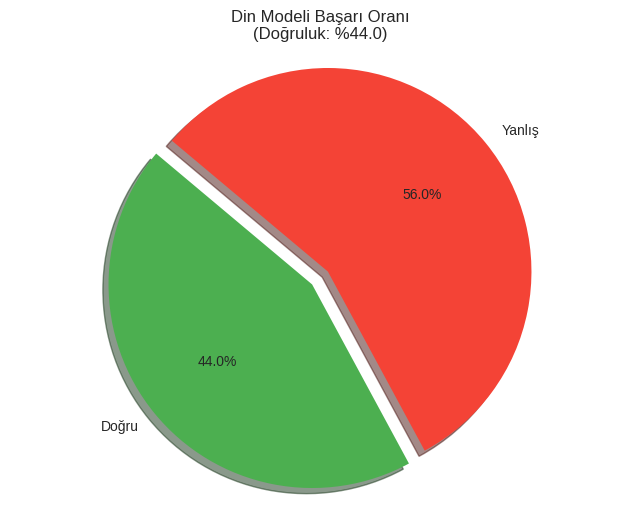

/tmp/ipython-input-1897518805.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")


📊 Sütun Grafiği Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari/din_sik_dagilimi.png


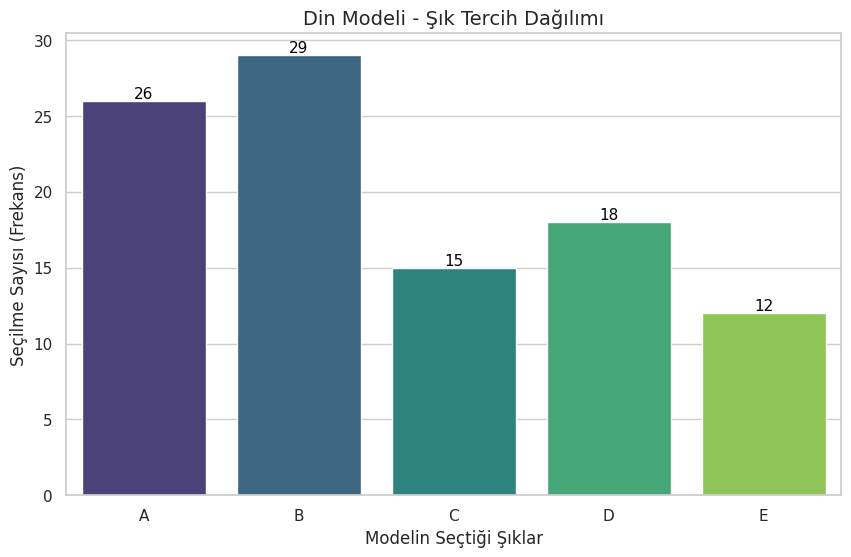

📄 Detaylı Rapor Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari/din_test_detaylari.json


In [5]:
from unsloth import FastLanguageModel
import torch
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# ==========================================
# 1. AYARLAR
# ==========================================
subject_name = "din"
model_path = f"/content/drive/MyDrive/Proje_Yedekleri/model_{subject_name}_uzmani"
test_file = f"/content/drive/MyDrive/Proje_Yedekleri/Sozel_Veriler/{subject_name}_test.json"
results_path = "/content/drive/MyDrive/Proje_Yedekleri/Test_Sonuclari"

# Klasör yoksa oluştur
os.makedirs(results_path, exist_ok=True)

print(f"🎓 {subject_name.upper()} MODELİ YÜKLENİYOR: {model_path}...")

# ==========================================
# 2. EĞİTİLMİŞ MODELİ YÜKLEME
# ==========================================
# Not: Load_in_4bit=True ile hafızadan tasarruf ediyoruz
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_path,
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model)

# ==========================================
# 3. TEST FONKSİYONU
# ==========================================
def run_test(question, options):
    opts_str = "\n".join([str(opt) for opt in options]) if isinstance(options, list) else str(options)

    # Eğitimdeki formatın AYNISI olmalı (Cevap kısmı hariç)
    prompt = f"""Aşağıdaki soruyu analiz et ve doğru seçeneği bul.

### Soru:
{question}

### Seçenekler:
{opts_str}

### Mantıksal Çözüm Yolu:""" # Model buradan devam edecek

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=256, # Rationale + Cevap için yer bırak
        use_cache=True,
        pad_token_id=tokenizer.eos_token_id,
        stop_strings=["<|end_of_text|>", "### Soru:"], # Sonsuz döngüye girmesin
        tokenizer=tokenizer
    )

    # Çıktıyı al
    generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Sadece yeni üretilen kısmı al (Prompt'u at)
    answer_part = generated_text.split("### Mantıksal Çözüm Yolu:")[-1].strip()
    return answer_part

# ==========================================
# 4. SINAV BAŞLIYOR
# ==========================================
print(f"\n📝 {subject_name.upper()} TESTİ BAŞLIYOR...")

with open(test_file, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

correct_count = 0
total_questions = len(test_data)
results_log = []

# İlerleme çubuğu ile test et
for item in tqdm(test_data):
    full_response = run_test(item['question'], item['options'])

    # Cevabı Ayıkla (Regex ile "Doğru Cevap: X" formatını ara)
    # Model eğitimi gereği "### Doğru Cevap:\nX" şeklinde bitirmeli.
    match = re.search(r"Doğru Cevap:\s*([A-E])", full_response, re.IGNORECASE)

    predicted_opt = match.group(1).upper() if match else "BOŞ"
    real_correct = item['correct'].strip().upper()

    is_correct = (predicted_opt == real_correct)
    if is_correct: correct_count += 1

    # Sonucu kaydet
    results_log.append({
        "question": item['question'],
        "predicted": predicted_opt,
        "actual": real_correct,
        "is_correct": is_correct,
        "model_output": full_response
    })

# ==========================================
# 5. SONUÇLARI HESAPLA VE ÇİZ (GÜNCELLENMİŞ)
# ==========================================
accuracy = (correct_count / total_questions) * 100

print(f"\n🏁 TEST BİTTİ!")
print(f"🎯 Doğru: {correct_count} / {total_questions}")
print(f"📊 Başarı Oranı: %{accuracy:.2f}")

# -------------------------------------------------
# GRAFİK 1: BAŞARI ORANI (PASTA GRAFİĞİ)
# -------------------------------------------------
labels_pie = ['Doğru', 'Yanlış']
sizes_pie = [correct_count, total_questions - correct_count]
colors_pie = ['#4CAF50', '#F44336'] # Yeşil ve Kırmızı
explode_pie = (0.1, 0)  # Doğru dilimini biraz dışarı çıkar

plt.figure(figsize=(8, 6))
plt.pie(sizes_pie, explode=explode_pie, labels=labels_pie, colors=colors_pie,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title(f"{subject_name.capitalize()} Modeli Başarı Oranı\n(Doğruluk: %{accuracy:.1f})")
plt.axis('equal')

# Kaydetme (Pasta Grafiği)
pie_graph_filename = f"{results_path}/{subject_name}_basari_pastasi.png"
plt.savefig(pie_graph_filename)
print(f"🖼️ Pasta Grafiği Kaydedildi: {pie_graph_filename}")
plt.show() # İlk grafiği göster ve kapat

# -------------------------------------------------
# GRAFİK 2: ŞIK TERCİH DAĞILIMI (SÜTUN GRAFİĞİ)
# -------------------------------------------------
# 1. Veriyi Hazırla
# results_log içindeki tüm tahminleri çekelim
predictions = [item['predicted'] for item in results_log]

# Pandas Serisi'ne çevirip saydıralım
pred_counts = pd.Series(predictions).value_counts()

# Standart bir sıra belirleyelim (A'dan E'ye ve varsa diğerleri)
standard_order = ['A', 'B', 'C', 'D', 'E']
# Eğer model saçma bir şey üretmişse onu da sona ekleyelim (Örn: "BOŞ")
existing_labels = [label for label in pred_counts.index if label not in standard_order]
final_order = standard_order + existing_labels

# Grafiği veriye göre yeniden düzenle (Olmayan şıklar 0 görünsün)
pred_counts = pred_counts.reindex(final_order, fill_value=0)

# 2. Grafiği Çiz
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Sütun grafiği oluştur
ax = sns.barplot(x=pred_counts.index, y=pred_counts.values, palette="viridis")

# Başlık ve Etiketler
plt.title(f"{subject_name.capitalize()} Modeli - Şık Tercih Dağılımı", fontsize=14)
plt.xlabel("Modelin Seçtiği Şıklar", fontsize=12)
plt.ylabel("Seçilme Sayısı (Frekans)", fontsize=12)

# Sütunların üzerine sayıları yazdıralım
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Kaydetme (Sütun Grafiği)
bar_graph_filename = f"{results_path}/{subject_name}_sik_dagilimi.png"
plt.savefig(bar_graph_filename)
print(f"📊 Sütun Grafiği Kaydedildi: {bar_graph_filename}")

plt.show() # İkinci grafiği göster

# -------------------------------------------------
# LOG KAYDI (JSON)
# -------------------------------------------------
json_filename = f"{results_path}/{subject_name}_test_detaylari.json"
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(results_log, f, indent=4, ensure_ascii=False)
print(f"📄 Detaylı Rapor Kaydedildi: {json_filename}")